In [1]:
import math
import random
import time

import numpy as np
import pandas as pd

import copy

In [2]:
ARRAY_SIZE = 4  # Features number
MAX_ITER = 5  # Max iterations to stop training on a given antigene
SEED = 0    # Fixed seed to use the same random numbers in different calls

# Mapping classes to integers

mapping = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
reverseMapping = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}

# Mutation rate for ARBs
# todo: pretty bad implementation, structure it.
MUTATION_RATE = 0.2



class AIRS:
    """AIRS (Artificial Immune Recognition System) class
    Main class for this algorithm
    Params:
        hyper_clonal_rate (float) : Define the number of clones an ARB is allowed to produce
        clonal_rate (float) : Define the number of ressources an ARB can obtain
        class_number (int) : The number of classes (3 in this case)
        mc_init_rate (float) : Define the number of training data to be copied in memory cells
        total_num_resources (float) : The total numbers of resources to share between ARBs
        affinity_threshold_scalar  (float) : Give a cut-off value for cell replacement
        k (int) : The number of memory cells to use for classification
        test_size (float) : The percentage of global data to take as test data

    """

    def __init__(self, hyper_clonal_rate, clonal_rate, class_number, mc_init_rate,
                 total_num_resources, affinity_threshold_scalar, k, test_size):
        self.HYPER_CLONAL_RATE = hyper_clonal_rate
        self.CLONAL_RATE = clonal_rate
        self.AFFINITY_THRESHOLD = 0
        self.CLASS_NUMBER = class_number
        self.MC_INIT_RATE = mc_init_rate
        self.TOTAL_NUM_RESOURCES = total_num_resources
        self.AFFINITY_THRESHOLD_SCALAR = affinity_threshold_scalar
        self.TEST_SIZE = test_size
        self.K = k
        self.MC = None
        self.AB = None
        self.MC_initial = None
        self.MC_iterations = []


    # calculates the affinity between two vectors
    # the affinity is the euclidian distance between the two vectors
    @staticmethod
    def affinity(vector1, vector2):
        """Compute the affinity (Normalized !! distance) between two features vectors
        :param vector1: First features vector
        :param vector2: Second features vector
        :return: The affinity between the two vectors [0-1]
        """
        d = 0
        for i, j in zip(vector1, vector2):
            d += (i - j) ** 2
        euclidian_distance = math.sqrt(d)
        return euclidian_distance / (1 + euclidian_distance)
    



    # splits the dataset into 2 parts (train and test)
    # the train/split size is defined by the variable TEST_SIZE
    def train_test_split(self):
        random.seed(SEED)
        with open("iris.data", "r") as data:
            content = data.readlines()
            ret = [([float(x.split(",")[i]) for i in range(4)], mapping[x.split(",")[4][:-1]]) for x in content]
            random.shuffle(ret)
        return ret[:int((1 - self.TEST_SIZE) * len(ret))], ret[int((1 - self.TEST_SIZE) * len(ret)):]




    # calculates the affinity threshold
    # it does so by calculating the average affinity between all the cells in the training set
    def calculate_affinity_threshold(self):
        train_set, test_set = self.train_test_split()
        affinity_threshold = 0
        for i in range(len(train_set)):
            for j in range(i + 1, len(train_set)):
                affinity_threshold += self.affinity(train_set[i][0], train_set[j][0])

        self.AFFINITY_THRESHOLD = affinity_threshold / (len(train_set) * (len(train_set) - 1) / 2)





    # takes a number of cells froms training_set (the number is defined by the variable MC_INIT_RATE)
    # creates a dictionary (MC) with the keys being the classes and the values being the cells
    def init_MC(self, train_set, MC):
        """ Init the memory set pool
        :param train_set: the training set
        :param MC: The memory set pool
        """
        for _ in range(int(len(train_set) * self.MC_INIT_RATE)):
            seed_cell = random.choice(train_set)
            MC[seed_cell[1]].append(Cell(vector=seed_cell[0], _class=seed_cell[1]))




    # takes the lists of ARBs (AB) and returns the ARB of a certain class with minimum ressources
    # it returns the ARB and its index in the ARB list (AB)
    def argminARB(self, AB, _class):
        """Get the ARB with the minimum amount of resources
        :param AB: The Artificial Recognition Balls set
        :param _class: the class of the ARBs
        :return: The ARB with the lower amount of resources and its index
        """
        minRes = 1.0
        ab = None
        abIndex = None
        for i in range(len(AB[_class])):
            if AB[_class][i].resources <= minRes:
                minRes = AB[_class][i].resources
                ab = AB[_class][i]
                abIndex = i
        return ab, abIndex




    # takes the ARB list (AB) and returns the ARB with the highest stimulation among a certain class
    # it returns it in Cell form (so it can be added to the memory cells pool)
    def getMcCandidate(self, AB, _class):
        """Get the higher stimulation ARB to be (eventually) added to the memory cells pool
        :param AB: The Artificial Recognition Balls set
        :param _class: the class of the ARBs
        :return: Higher stimulation ARB of the given class
        """
        maxStim = 0.0
        ab = None
        for i in range(len(AB[_class])):
            if AB[_class][i].stimulation >= maxStim:
                maxStim = AB[_class][i].stimulation
                ab = AB[_class][i]
        c = Cell(vector=ab.vector, _class=ab._class)
        c.stimulation = ab.stimulation
        return c




    def train(self):
        """Training method"""
        start = time.time()
        train_set, test_set = self.train_test_split()    # spliting the dataset and getting train_set and test_set

        # the default affinity threshold is calculated (the average affinity between all the cells in the training set)
        self.calculate_affinity_threshold()

        # MC and AB are dictionaries with the keys being the classes and the values being the cells
        # the dictionaries are both in this form
        # MC = {0: [], 1: [], 2: []}
        # AB = {0: [], 1: [], 2: []}
        MC = {_class: [] for _class in range(self.CLASS_NUMBER)}
        MC_initial = {_class: [] for _class in range(self.CLASS_NUMBER)}
        AB = {_class: [] for _class in range(self.CLASS_NUMBER)}

        # MC Initialisation
        self.init_MC(train_set, MC)
        # self.init_MC(train_set, MC_initial)
        MC_initial = copy.deepcopy(MC)
        self.MC_initial = MC_initial



        # looping every antigene with its known class form the training set
        for antigene, _class in train_set:

            # MC Identification
            mc_match = None
            if len(MC[_class]) == 0:
                # if there is no memory cell of the same class, then add it directly to the MC pool
                mc_match = Cell(vector=antigene, _class=_class)
                MC[_class].append(mc_match)
            else:
                # running through every memory cell of that class
                # stimulating each memory cell with the current antigene
                # getting the antigene with the highest stimulation as the best match (mc_match)
                best_stim = 0
                for c in MC[_class]:
                    if c.stimulate(antigene) >= best_stim:
                        best_stim = c.stimulation
                        mc_match = c

            # ARB Generation
            AB[_class].append(ARB(vector=mc_match.vector, _class=mc_match._class))  # add the mc_match to ARBs
            stim = mc_match.stimulate(antigene)  # get the stimulation of the mc_match with the current antigene

            iterations = 0
            while True:
                iterations += 1
                MAX_CLONES = int(self.HYPER_CLONAL_RATE * self.CLONAL_RATE * stim)
                num_clones = 0

                while num_clones < MAX_CLONES:
                    clone, mutated = mc_match.mutate()

                    if mutated:
                        AB[_class].append(clone)
                        num_clones += 1

                # Competition for resources
                avgStim = sum([x.stimulate(antigene) for x in AB[_class]]) / len(AB[_class])    # getting the average stimulation for every ARB of the class with the current antigene

                MIN_STIM = 1.0
                MAX_STIM = 0.0

                # loops over all the ARBs of all the classes to find the Min and Max stimulations
                for c in AB.keys():
                    for ab in AB.get(c):
                        stim = ab.stimulate(antigene)
                        if stim < MIN_STIM:
                            MIN_STIM = stim
                        if stim > MAX_STIM:
                            MAX_STIM = stim

                # Normalizing the resources
                # the resources are normalized between 0 and 1
                # ressource is calculated for all the ARBs as follows:
                # ressource = (stimulation - MIN_STIM) / (MAX_STIM - MIN_STIM) * CLONAL_RATE
                for c in AB.keys():
                    for ab in AB.get(c):
                        ab.stimulation = (ab.stimulation - MIN_STIM) / (MAX_STIM - MIN_STIM)
                        ab.resources = ab.stimulation * self.CLONAL_RATE


                # competition for ressources
                # if the sum of the resources allocated to the ARBs of the class is greater than the TOTAL_NUM_RESOURCES
                # then we remove the ARB with the lowest resources
                resAlloc = sum([x.resources for x in AB[_class]])  # calcultates the sum of the resources allocated to the ARBs of the class
                numResAllowed = self.TOTAL_NUM_RESOURCES
                while resAlloc > numResAllowed:
                    numResRemove = resAlloc - numResAllowed
                    abRemove, abRemoveIndex = self.argminARB(AB=AB, _class=_class)  # find the ARB with the lowest resources

                    # remove the ARB with the lowest resources
                    if abRemove.resources <= numResRemove:
                        AB[_class].remove(abRemove)
                        resAlloc -= abRemove.resources
                    else:
                        # if the ARB with the lowest resources has more resources than the number of resources to remove
                        # then we remove the number of resources to remove from the ARB
                        AB[_class][abRemoveIndex].resources -= numResRemove
                        resAlloc -= numResRemove

                # if the average stimulation is greater than the affinity threshold or the number of iterations is greater than MAX_ITER
                # then we stop the training on the current antigene
                if (avgStim > self.AFFINITY_THRESHOLD) or (iterations >= MAX_ITER):
                    # avgStim is the average stimulation of all the ARBs of the class with the current antigene
                    # self.AFFINITY_THRESHOLD is the affinity threshold calculated by the average affinity between all the cells in the training set
                    break

            mc_candidate = self.getMcCandidate(AB=AB, _class=_class)    # get the ARB with the highest stimulation of the class

            # comparing the stimulation of the higest stim ARB with the best match memory cell for the antigene
            if mc_candidate.stimulation > mc_match.stimulation:
                if AIRS.affinity(mc_candidate.vector, mc_match.vector) < self.AFFINITY_THRESHOLD * self.AFFINITY_THRESHOLD_SCALAR:
                    MC[_class].remove(mc_match)      # The mc candidate replaces the mc match
                MC[_class].append(mc_candidate)     # Add the mc_match to MC pool

            self.MC_iterations.append(copy.deepcopy(MC))  # appendice

        # update the memory cell pool and the are pool
        self.MC = MC
        self.AB = AB

        print(len(self.MC_iterations))




        # Testing
        n_correct = 0
        for ag, _class in test_set:
            if self.classify(ag) == reverseMapping[_class]:
                n_correct += 1

        # print("Execution time : {:2.4f} seconds".format(time.time() - start))
        # print("Accuracy : {:2.2f} %".format(n_correct * 100 / len(test_set)))
        return n_correct / len(test_set)




    # classify a given antigene
    # the classification is done by stimulating all the memory cells of all the classes with the antigene
    # the K memory cells with the highest stimulations are selected
    # the class of the antigene is the class with the highest number of votes
    def classify(self, antigene):
        if (self.MC is None) or (self.AB is None):
            raise Exception("AIRS must be trained first")   # if classify is called before airs has been trained -> raise an error

        vote_array = []
        # getting the stimulation of all the memory cells of all the classes with the antigene
        for c in self.MC.keys():
            for ab in self.MC.get(c):
                ab.stimulate(antigene)
                vote_array.append(ab)


        vote_array = list(sorted(vote_array, key=lambda cell: -cell.stimulation))     # sort the memory cells by their stimulations
        v = {0: 0, 1: 0, 2: 0}                                # dictionary to store the number of votes for each class
        self.K = min(self.K, len(vote_array))              # the number of memory cells to use for classification is the minimum between K and the number of memory cells
        
        for x in vote_array[:self.K]:                   # loop over the K memory cells with the highest stimulations
            v[x._class] += 1                            # increment the number of votes for the class of the memory cell

        # getting the class with the highest number of votes
        maxVote = 0
        _class = 0
        for x in v.keys():
            if v[x] > maxVote:
                maxVote = v[x]
                _class = x
        return reverseMapping[_class]




class ARB:
    """ARB (Artificial Recognition Ball) class
    Args:
        vector (list) : list of features
        _class (integer) : the class of the previous features
    """

    def __init__(self, vector=None, _class=None):
        if vector is None:
            self.vector = [random.random() for _ in range(ARRAY_SIZE)]
        else:
            self.vector = vector
        self._class = _class
        self.stimulation = float('inf')
        self.resources = 0

    def __str__(self):
        return "ARB : Vector = {} | class = {} | stim = {} | res = {}".format(self.vector, self._class,
                                                                              self.stimulation, self.resources)

    def __repr__(self):
        return "ARB : Vector = {} | class = {} | stim = {} | res = {}".format(self.vector, self._class,
                                                                              self.stimulation, self.resources)

    def stimulate(self, pattern):
        self.stimulation = 1 - AIRS.affinity(vector1=pattern, vector2=self.vector)
        return self.stimulation

    def mutate(self):
        _range = 1 - self.stimulation
        mutated = False
        new_vector = []

        # hardcoded min, max values for each feature
        min_features = [4.3, 2.0, 1.0, 0.1]
        max_features = [7.9, 4.4, 6.9, 2.5]

        for idx, v in enumerate(self.vector):
            change = random.random()
            # could have been something like min_features[idx]*(1 - some-percentage) and max_features[idx] * (1 + some-percentage)
            change_to = random.uniform(min_features[idx], max_features[idx])

            if change <= MUTATION_RATE:
                new_vector.append(change_to)
                mutated = True
            else:
                new_vector.append(v)
        return ARB(vector=new_vector, _class=self._class), mutated
    



class Cell:
    """Cell class
    Args:
        vector (list) : list of features
        _class (integer) : the class of the previous features
    """

    def __init__(self, vector=None, _class=None):
        if vector is None:
            self.vector = [random.random() for _ in range(ARRAY_SIZE)]
        else:
            self.vector = vector
        self._class = _class
        self.stimulation = float('inf')

    def __str__(self):
        return "Cell : Vector = {} | class = {} | stim = {}".format(self.vector, self._class, self.stimulation)

    def __repr__(self):
        return "Cell : Vector = {} | class = {} | stim = {}".format(self.vector, self._class, self.stimulation)

    def stimulate(self, pattern):
        self.stimulation = 1 - AIRS.affinity(vector1=pattern, vector2=self.vector)
        return self.stimulation

    def mutate(self):
        _range = 1 - self.stimulation
        mutated = False
        new_vector = []

        # hardcoded min, max values for each feature
        min_features = [4.3, 2.0, 1.0, 0.1]
        max_features = [7.9, 4.4, 6.9, 2.5]

        for idx, v in enumerate(self.vector):
            change = random.random()
            change_to = random.uniform(min_features[idx], max_features[idx])

            if change <= MUTATION_RATE:
                new_vector.append(change_to)
                mutated = True
            else:
                new_vector.append(v)
        return Cell(vector=new_vector, _class=self._class), mutated

In [3]:
airs = AIRS(hyper_clonal_rate=20, clonal_rate=0.8, class_number=3, mc_init_rate=0.4,
                total_num_resources=10, affinity_threshold_scalar=0.8, k=3, test_size=0.4)

print(airs.train())

90
0.9833333333333333



{0: [Cell : Vector = [4.6, 3.4, 1.4, 0.3] | class = 0 | stim = 0.3263732343727084, Cell : Vector = [5.5, 3.5, 1.3, 0.2] | class = 0 | stim = 0.3120571939131762, Cell : Vector = [4.9, 3.1, 1.5, 0.1] | class = 0 | stim = 0.34358389337897355, Cell : Vector = [5.4, 3.9, 1.3, 0.4] | class = 0 | stim = 0.30027901569891846, Cell : Vector = [5.8, 4.0, 1.2, 0.2] | class = 0 | stim = 0.27733382455251754, Cell : Vector = [5.4, 3.4, 1.7, 0.2] | class = 0 | stim = 0.3516287047744072, Cell : Vector = [4.6, 3.4, 1.4, 0.3] | class = 0 | stim = 0.3263732343727084, Cell : Vector = [5.1, 3.7, 1.5, 0.10158408812535874] | class = 0 | stim = 0.3159647734535569, Cell : Vector = [5.1, 3.307350906903113, 1.7, 0.5] | class = 0 | stim = 0.37825488116070316, Cell : Vector = [5.1, 3.7246217567556887, 1.7, 0.41895484890993306] | class = 0 | stim = 0.3434751741763832, Cell : Vector = [4.6, 3.2899754630791085, 1.5, 0.2] | class = 0 | stim = 0.3351827818702542, Cell : Vector = [5.5, 4.046652899638152, 1.3, 0.2] | cla

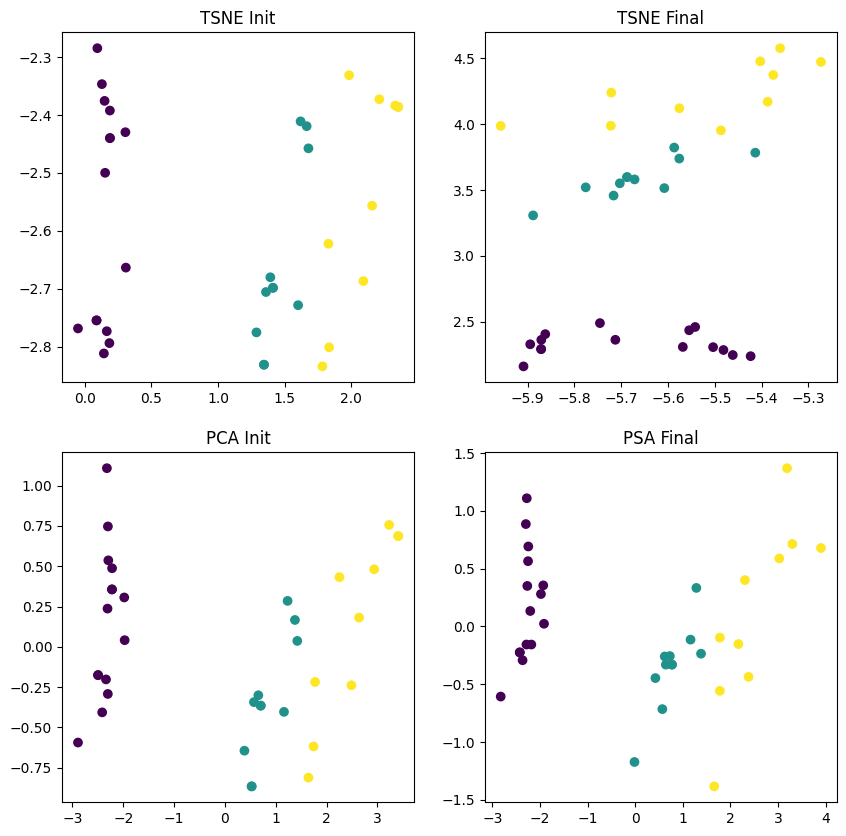

In [ ]:
import matplotlib.pyplot as plt
MC_final = airs.MC
MC_initial = airs.MC_initial
print('')
print(MC)
print('')
print(MC_initial)
print('')

X = []
Y = []
X_init = []
Y_init = []

# getting the final MC array vectors and classes
for c in MC_final.keys():
    for cell in MC_final[c]:
        X.append(cell.vector)
        Y.append(c)
X = np.array(X)
Y = np.array(Y)

# getting the initial MC array vectors and classes
for c in MC_initial.keys():
    for cell in MC_initial[c]:
        X_init.append(cell.vector)
        Y_init.append(c)
X_init = np.array(X_init)
Y_init = np.array(Y_init)


plt.figure(figsize=(10, 10))

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# initial MC visualization using TSNE
X_embedded_TSNE_init = TSNE(n_components=2).fit_transform(X_init)
plt.subplot(2, 2, 1)
plt.title("TSNE Init")
plt.scatter(X_embedded_TSNE_init[:, 0], X_embedded_TSNE_init[:, 1], c=Y_init)

# initial MC visualization using PCA
X_embedded_PCA_init = PCA(n_components=2).fit_transform(X_init)
plt.subplot(2, 2, 3)
plt.title("PCA Init")
plt.scatter(X_embedded_PCA_init[:, 0], X_embedded_PCA_init[:, 1], c=Y_init)




# final MC visualization using TSNE
X_embedded_TSNE = TSNE(n_components=2).fit_transform(X)
plt.subplot(2, 2, 2)
plt.title("TSNE Final")
plt.scatter(X_embedded_TSNE[:, 0], X_embedded_TSNE[:, 1], c=Y)

# final MC visualization using PCA
X_embedded_PCA = PCA(n_components=2).fit_transform(X)
plt.subplot(2, 2, 4)
plt.title("PSA Final")
plt.scatter(X_embedded_PCA[:, 0], X_embedded_PCA[:, 1], c=Y)

plt.show()

In [5]:
# generate imgs of all iterations for animating the memory cells evolution

MC_iterations = airs.MC_iterations

# for i in range(len(MC_iterations)):
#     MC = MC_iterations[i]
#     X = []
#     Y = []
#     for c in MC.keys():
#         for cell in MC[c]:
#             X.append(cell.vector)
#             Y.append(c)

#     X = np.array(X)
#     Y = np.array(Y)

#     plt.figure(figsize=(10, 10))

#     X_embedded_TSNE = TSNE(n_components=2).fit_transform(X)
#     plt.subplot(2, 2, 1)
#     plt.title("TSNE Final")
#     plt.scatter(X_embedded_TSNE[:, 0], X_embedded_TSNE[:, 1], c=Y)

#     X_embedded_PCA = PCA(n_components=2).fit_transform(X)
#     plt.subplot(2, 2, 2)
#     plt.title("PSA Final")
#     plt.scatter(X_embedded_PCA[:, 0], X_embedded_PCA[:, 1], c=Y)
#     plt.xlim(-3, 4)
#     plt.ylim(-1, 1.5)

#     plt.savefig("MC_evolution_{}.png".format(i))
#     plt.close()
